In [1]:
import copy
import random
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import math
import torchvision.transforms as T
import numpy as np
import time
import socket
from IPython.display import clear_output

In [2]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    #clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(500, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    ax[0].legend()
    # Calculate the trend
    #try:
    #print(values)
    x = range(len(values))
    #x = np.arange(1,len(values) + 1)
    #print(x)
    z = np.polyfit(x, values, 1)
    #print(z, '\n\n')
    p = np.poly1d(z)
    ax[0].plot(x,p(x),"--", label='trend')
    #except:
    #print('Error')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [3]:
class Game_Ampliado():
    def __init__(self, host="localhost", port=38514, numEpisodes = 100):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.episodes = numEpisodes
        try:
            self.sock.bind((host, port))
        except socket.error as err:
            print('Bind failed. Error Code : ' .format(err))
        
    def connect(self):
        self.sock.listen(1)
        self.conn, _ = self.sock.accept()
        self.conn.send(bytes(str(self.episodes) + "\n",'UTF-8'))
        
    def get_state(self):
        data = self.conn.recv(512)
        data = data.decode(encoding='UTF-8')
        lista=data.split(";")
        reward= int(lista[1])
        #print(data)
        if lista[0] == "gameOver":
            return None, reward
            
        lista_estado=lista[0].split("/")
        
        list_dist_pills=list(map(int, lista_estado[0].replace("[","").replace("]","").split(",")))
        list_dist_power_pills=list(map(int, lista_estado[1].replace("[","").replace("]","").split(",")))
        num_pills=int (lista_estado[2])
        num_power_pills= int (lista_estado[3])
        current_time = int(lista_estado[4])
        list_dist_ghosts=list(map(int, lista_estado[5].replace("[","").replace("]","").split(",")))
        list_dir_ghosts=list(map(int, lista_estado[6].replace("[","").replace("]","").split(",")))
        list_edible_ghosts=list(map(int, lista_estado[7].replace("[","").replace("]","").split(",")))
        lair_time= int (lista_estado[8])
        
        next_state=list_dist_pills+ list_dist_power_pills + list_dist_ghosts + list_dir_ghosts + list_edible_ghosts + [num_pills, num_power_pills, current_time, lair_time]
        #print(next_state)
        return next_state,reward
    
    def send_action(self, action):
        self.conn.send(bytes(str(action) + "\n",'UTF-8'))

In [4]:
def q_learning_ampliado(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game_Ampliado(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()    
           
            
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()
            
            if next_state is None:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
            
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = next_state
            
        
        final.append(total)
        plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #torch.save(model, "model.mdl")
    return sum(final) / len(final)

In [5]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim))
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr) #cambiar
        
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        tensor = torch.Tensor(state)
        y_pred = self.model(tensor)
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

[1620]
range(0, 1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:659: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

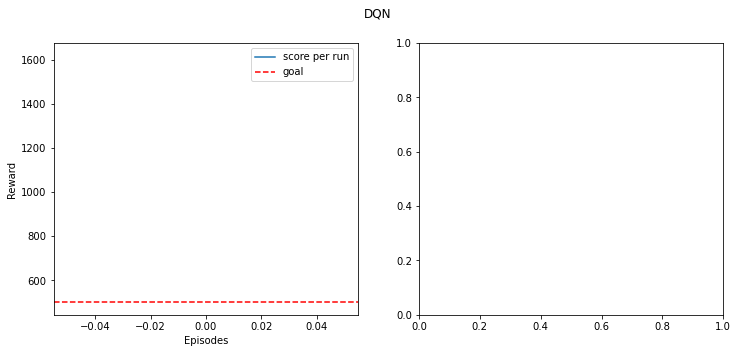

In [6]:
action_dim = 4
hidden_dim = 200
lr = 0.05
state_dim = 24
model = DQN(state_dim, action_dim, hidden_dim, lr)
episodes = 100
gamma = 0.7
q_learning_ampliado(model, episodes=30)